In [ ]:
!pip install tensorflow==2.3.0
!pip install causalml

In [1]:
!wget http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

--2021-03-20 15:49:17--  http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz
Resolving go.criteo.net (go.criteo.net)... 178.250.0.152
Connecting to go.criteo.net (go.criteo.net)|178.250.0.152|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo-uplift-v2.1.csv.gz [following]
--2021-03-20 15:49:17--  https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo-uplift-v2.1.csv.gz
Resolving criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)... 52.239.220.32
Connecting to criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)|52.239.220.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311422618 (297M) [application/x-gzip]
Saving to: ‘criteo-research-uplift-v2.1.csv.gz’

criteo-research-upl 100%[===================>] 297.00M  41.5MB/s    in 7.7s    

2021-03-20 15:49:25 (38.6 MB/s) - ‘criteo-research-upl

In [2]:
!ls

criteo-research-uplift-v2.1.csv.gz  sample_data


In [3]:
import requests
import gzip

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import lightgbm as lgbm

from causalml.inference.meta import BaseTClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from causalml.metrics import auuc_score, qini_score
from causalml.metrics import plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [25]:
# Get data
with gzip.open('criteo-research-uplift-v2.1.csv.gz') as f:
    data = pd.read_csv(f)

In [26]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [27]:
data.shape, data.shape[0] / 100

((13979592, 16), 139795.92)

In [28]:
# Take a subset of data
data = data.sample(frac=.01)

data.shape

(139796, 16)

In [29]:
# Check if treatment assigned randomly
features_names = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"]

x_data = data[features_names].values

x_train, x_test, treatment_train, treatment_test = train_test_split(
        x_data, data['treatment'].values, test_size=0.2, random_state=42
    )

model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, treatment_train)

preds = model.predict_proba(x_test)

roc_auc_score(treatment_test, preds[:, 1])

0.4945420684657948

In [30]:
# del model

## Model

### T-Learner

In [31]:
x_train, x_test, treatment_train, treatment_test, outcome_train, outcome_test = train_test_split(
        x_data, data['treatment'].values, data['visit'].values, test_size=0.2, random_state=42
    )

In [32]:
%%time
xgb_tlearner = BaseTClassifier(learner=XGBClassifier(random_state=42, n_estimators = 300,
                               max_depth = 5, learning_rate = 0.1))

xgb_tlearner.fit(X=x_train, y=outcome_train, treatment=treatment_train)

CPU times: user 28.1 s, sys: 88.4 ms, total: 28.2 s
Wall time: 28.2 s


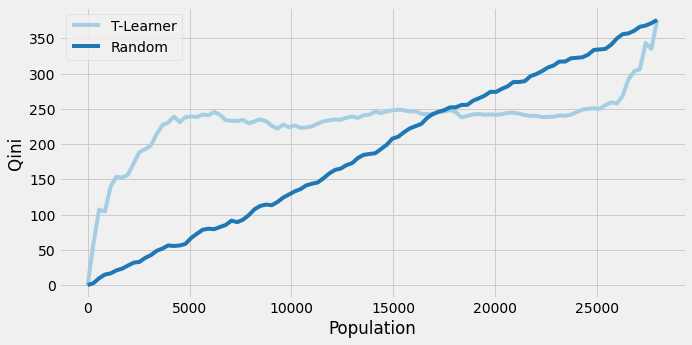

In [33]:
t_pred = xgb_tlearner.predict(X=x_test)

## Aggregating everything on a dataframe
valid_t = pd.DataFrame({'y': outcome_test,
                        'w': treatment_test,
                        'T-Learner': t_pred.reshape(-1), 
                      })

## Plotting the 3 types of uplift curve. 
plot(valid_t, kind='qini', outcome_col='y', treatment_col='w', figsize=(10, 5))

In [34]:
print('AUUC:\n',auuc_score(valid_t))

AUUC:
 T-Learner    0.617128
Random       0.502077
dtype: float64


### Uplift tress

In [35]:
%%time
uplift_tree = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name="control")

uplift_tree.fit(x_train,
                 np.where(treatment_train < 1, "control", "treatment"),
                 y=outcome_train)

CPU times: user 4.18 s, sys: 222 ms, total: 4.41 s
Wall time: 4.42 s


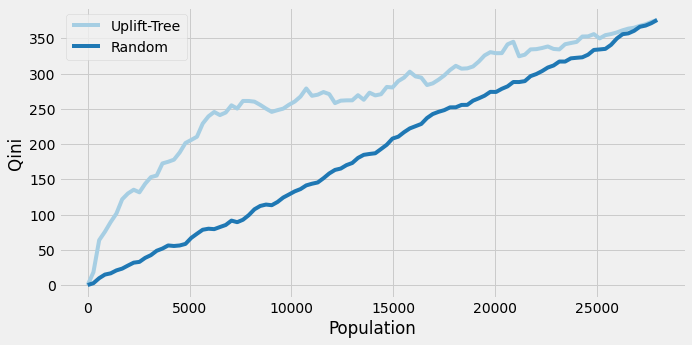

In [36]:
tree_pred = uplift_tree.predict(X=x_test)[1]

## Aggregating everything on a dataframe
valid_tree = pd.DataFrame({'y': outcome_test,
                           'w': treatment_test,
                           'Uplift-Tree': tree_pred, 
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_tree, kind='qini', outcome_col='y', treatment_col='w', figsize=(10, 5))

In [37]:
print('AUUC:\n',auuc_score(valid_tree))

AUUC:
 Uplift-Tree    0.710468
Random         0.502077
dtype: float64


### Uplift Forest

In [38]:
%%time
uplift_forest = UpliftRandomForestClassifier(n_estimators=400, max_depth=14, min_samples_leaf=80, min_samples_treatment=50,
                                    n_reg=10, evaluationFunction='KL', control_name="control")

uplift_forest.fit(x_train,
                 np.where(treatment_train < 1, "control", "treatment"),
                 y=outcome_train)

CPU times: user 7.63 s, sys: 715 ms, total: 8.35 s
Wall time: 43min 24s


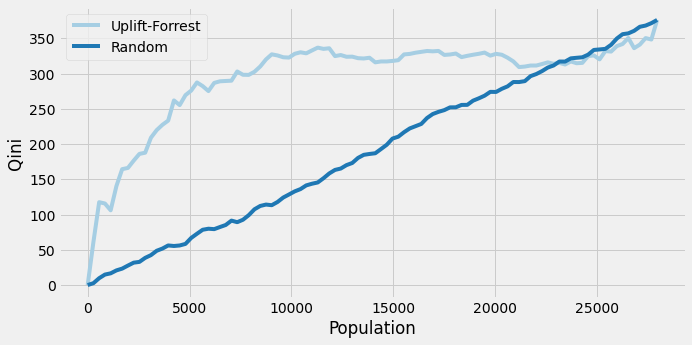

In [39]:
forest_pred = uplift_forest.predict(X=x_test)

## Aggregating everything on a dataframe
valid_forest = pd.DataFrame({'y': outcome_test,
                             'w': treatment_test,
                             'Uplift-Forrest': forest_pred.reshape(-1), 
                            })

## Plotting the 3 types of uplift curve. 
plot(valid_forest, kind='qini', outcome_col='y', treatment_col='w', figsize=(10, 5))

In [40]:
print('AUUC:\n', auuc_score(valid_forest))

AUUC:
 Uplift-Forrest    0.782539
Random            0.502077
dtype: float64


### Propensity score

In [41]:
%%time
model_prop = XGBClassifier(random_state=42, n_estimators = 200,
                               max_depth = 4, learning_rate = 0.1)
model_prop.fit(x_train[treatment_train == 1], outcome_train[treatment_train == 1])

CPU times: user 13.6 s, sys: 29.8 ms, total: 13.6 s
Wall time: 13.6 s


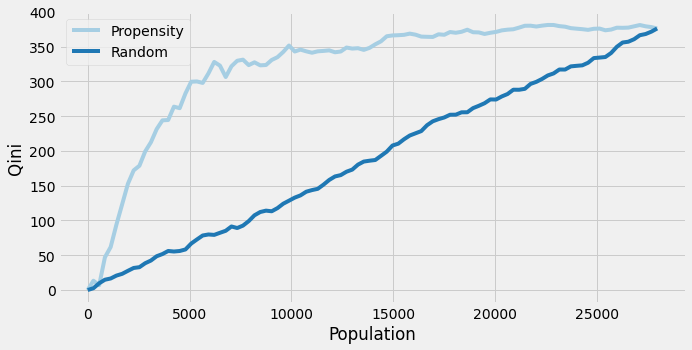

In [42]:
## Aggregating everything on a dataframe
valid_prop = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                   'Propensity': model_prop.predict_proba(x_test)[:,1], 
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_prop, kind='qini', outcome_col='y', treatment_col='w', figsize=(10, 5))

In [43]:
print('AUUC:\n',auuc_score(valid_prop))

AUUC:
 Propensity    0.852627
Random        0.502077
dtype: float64


## Comparison

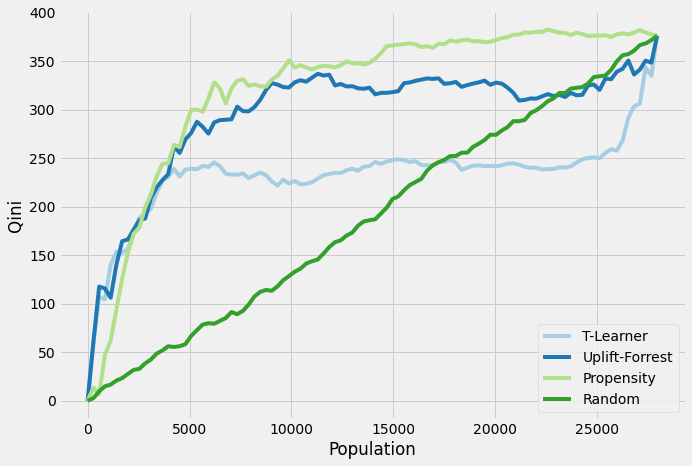

In [44]:
valid_all = pd.DataFrame({'y': outcome_test,
                   'w': treatment_test,
                    'T-Learner': t_pred.reshape(-1),
                   'Uplift-Forrest': forest_pred.reshape(-1), 
                    'Propensity': model_prop.predict_proba(x_test)[:,1]
                   })

## Plotting the 3 types of uplift curve. 
plot(valid_all,kind='qini', outcome_col='y', treatment_col='w', figsize=(10, 7))

In [45]:
print('AUUC:\n', auuc_score(valid_all))

AUUC:
 T-Learner         0.617128
Uplift-Forrest    0.782539
Propensity        0.852627
Random            0.502077
dtype: float64
